In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [3]:
df = pd.read_csv("clutch_events.csv")

#print(df.shape)
#print(df.head())


In [4]:
y = df["clutch_success"]

drop_cols = [
    "clutch_success", 
    "clutch_kills",    
    "demo_file",       
    "map",            
    "player_name", 
    "steamid64"
]

drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (655, 20) Test size: (164, 20)


In [6]:
# Separate numerical & categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical:", num_features)
print("Categorical:", cat_features)

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


Numerical: ['round', 'start_tick', 'start_time_s', 'time_left_s', 'start_vs', 'teammates_alive', 'enemies_alive', 'player_hp', 'player_armor', 'has_helmet', 'has_kit', 'player_equip_value', 'enemy_equip_value', 'bomb_planted', 'time_since_plant_s', 'round_end_reason']
Categorical: ['side', 'plant_site', 'weapon', 'round_winner_side']


In [23]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\vagge\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:44:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['round',
                                                                          'start_tick',
                                                                          'start_time_s',
                                                                          'time_left_s',
                                                                          'start_vs',
                                                                          'teammates_alive',
                                                                          'enemies_alive',
                                                                          'player_hp',
                                                                          'player_armor',
                                                                          'has_helmet',
                                                                          'has_kit',
                                                                          'player_equip_value',
                                                                          'enemy_equip_value',
                                                                          'bomb_planted',
                                                                          'time_since_plant_s',
                                                                          'round_end_...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                       0.3],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='recall', verbose=2)

In [24]:
best_xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test)

print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print(classification_report(y_test, y_pred_xgb, zero_division=0))


Best XGBoost Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       154
           1       1.00      0.60      0.75        10

    accuracy                           0.98       164
   macro avg       0.99      0.80      0.87       164
weighted avg       0.98      0.98      0.97       164



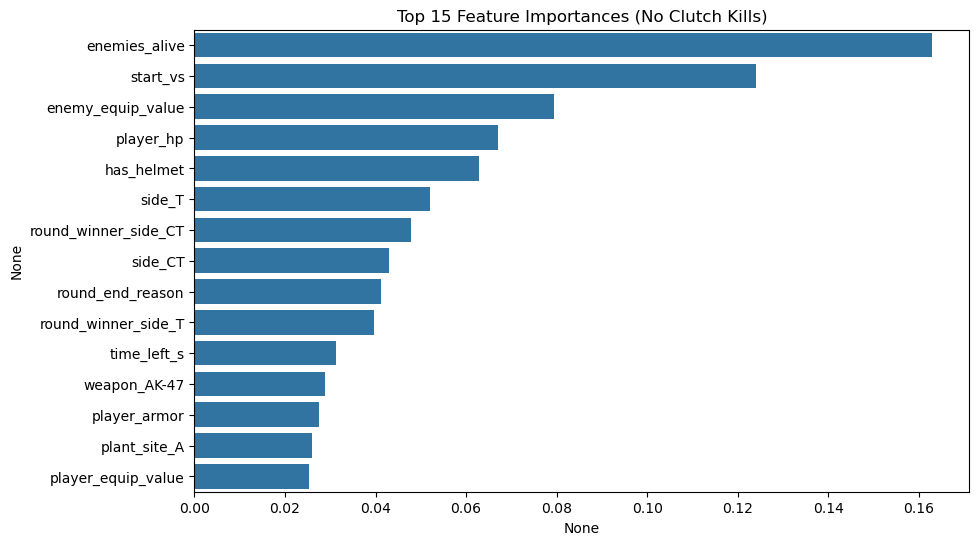

In [15]:
# feature names after preprocessing
feature_names = (
    num_features +
    list(clf.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features))
)

importances = clf.named_steps["classifier"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# top 15
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index)
plt.title("Top 15 Feature Importances (No Clutch Kills)")
plt.show()


### 1. **Enemy Equipment Value** (most important)
- The total value of enemy gear (weapons, armor, utility) is the single strongest predictor.  
- Higher enemy equipment value makes a clutch **less likely**, since opponents are better armed.  

---

### 2. **Player HP**
- The second most important feature.  
- A player with higher HP has a significantly better chance of winning a clutch.  

---

### 3. **Start_vs (Starting Advantage)**
- Represents how many opponents the clutching player faces at the start.  
- Fewer enemies = higher clutch probability.  

---

### 4. **Enemies Alive**
- Closely related to *start_vs*.  
- The fewer enemies alive, the easier the clutch.  

---

### 5. **Time Left in Round**
- Having more time gives the clutching player flexibility to reposition, bait, and attempt defuses or plants.  
- Shorter time reduces chances drastically.  

---

### 6. **Player Equipment Value**
- The clutching player’s own equipment is important.  
- Better guns, armor, and utility increase the odds of winning.  

---

### 7. **Side (T or CT)**
- Whether the player is **Terrorist (T)** or **Counter-Terrorist (CT)** matters.  
- Certain clutch scenarios are easier depending on the side (e.g., Ts after bomb plant, CTs on retake).  

---

### 8–15. **Other Contributing Factors**
- **Start tick / Start time**: Proxy for round progression.  
- **Time since plant**: Defusal pressure plays a role.  
- **Player armor & helmet**: Reduce vulnerability.  
- **Round winner side & round end reason**: Contextual round dynamics also influence outcomes.  

---

## Takeaway
- The model emphasizes **economic strength (equipment value)** and **basic survival factors (HP, enemies alive, time left)** as the most critical clutch determinants.  
- Tactical elements like bomb plant timing and side also shape outcomes, but less strongly.  

---

This analysis also makes sense intuitively: clutches are most likely when you’re **healthy, well-equipped, facing fewer enemies, and with enough time to work with**.  


In [25]:
#save model

import joblib

joblib.dump(clf, "cs2_clutch_model.pkl")

loaded_model = joblib.load("cs2_clutch_model.pkl")

y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded, zero_division=0))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       154
           1       1.00      0.60      0.75        10

    accuracy                           0.98       164
   macro avg       0.99      0.80      0.87       164
weighted avg       0.98      0.98      0.97       164

